In [1]:
rm(list = ls())

In [2]:
library(loadeR)
library(transformeR)
library(visualizeR)

Warning message:
"package 'loadeR' was built under R version 3.6.3"Loading required package: rJava
Warning message:
"package 'rJava' was built under R version 3.6.3"Loading required package: loadeR.java
Warning message:
"package 'loadeR.java' was built under R version 3.6.3"Java version 21x amd64 by Azul Systems, Inc. detected
NetCDF Java Library v4.6.0-SNAPSHOT (23 Apr 2015) loaded and ready
Loading required package: climate4R.UDG
Warning message:
"package 'climate4R.UDG' was built under R version 3.6.3"climate4R.UDG version 0.2.6 (2023-06-26) is loaded
Please use 'citation("climate4R.UDG")' to cite this package.
loadeR version 1.8.1 (2023-06-22) is loaded
Please use 'citation("loadeR")' to cite this package.
Warning message:
"package 'transformeR' was built under R version 3.6.3"


    _______   ____  ___________________  __  ________ 
   / ___/ /  / /  |/  / __  /_  __/ __/ / / / / __  / 
  / /  / /  / / /|_/ / /_/ / / / / __/ / /_/ / /_/_/  
 / /__/ /__/ / /  / / __  / / / / /__ /___  / / \ \ 
 \___/____/_/_/  /_/_/ /_/ /_/  \___/    /_/\/   \_\ 
 
      github.com/SantanderMetGroup/climate4R



transformeR version 2.2.2 (2023-10-26) is loaded
Please see 'citation("transformeR")' to cite this package.
Warning message:
"package 'visualizeR' was built under R version 3.6.3"visualizeR version 1.6.4 (2023-10-26) is loaded
Please see 'citation("visualizeR")' to cite this package.


# Datos

In [3]:
load("pr_iberia01_1971-2015.Rdata")
pr <- data

In [3]:
load("tasmax_iberia01_1971-2015.Rdata")
tmax <- data

In [4]:
rm(data)

# Reference Quantile

Por estación i.e.
pr$Winter / pr$Spring / pr$Summmer / pr$Autumn

This function `ref_quantile`, calculate the reference quantiles, that are used later to make a comparison and binarize the data to work with.

In [6]:
seasons <- list(Winter = c(12, 1, 2), Spring = c(3, 4, 5), Summer = c(6, 7, 8), Autumn = c(9, 10, 11))
# Function to apply climatology to a dataset for a specific season and quantile level
ref_quantile <- function(data, quantile) {
    # data: a grid with the data
    # quantile: number of the quantile to calculate
  results <- list()
  for (season_name in names(seasons)) {
    season_month <- seasons[[season_name]]
    season_data <- subsetGrid(data, season = season_month)
    quantile_result <- climatology(season_data, clim.fun = list(FUN = "quantile", probs = quantile, na.rm = TRUE))
    results[[season_name]] <- quantile_result
  }
  return(results)
}

In [7]:
pr05 <- ref_quantile(pr, 0.05)
tmax95 <- ref_quantile(tmax, 0.95)

NOTE: Some data will be lost on year-crossing season subset (see the 'Time slicing' section of subsetGrid documentation for more details)
[2024-02-27 13:24:54] - Computing climatology...
[2024-02-27 13:24:57] - Done.
[2024-02-27 13:25:00] - Computing climatology...
[2024-02-27 13:25:03] - Done.
[2024-02-27 13:25:05] - Computing climatology...
[2024-02-27 13:25:09] - Done.
[2024-02-27 13:25:10] - Computing climatology...
[2024-02-27 13:25:16] - Done.
NOTE: Some data will be lost on year-crossing season subset (see the 'Time slicing' section of subsetGrid documentation for more details)
[2024-02-27 13:25:26] - Computing climatology...
[2024-02-27 13:25:32] - Done.
[2024-02-27 13:25:34] - Computing climatology...
[2024-02-27 13:25:37] - Done.
[2024-02-27 13:25:38] - Computing climatology...
[2024-02-27 13:25:41] - Done.
[2024-02-27 13:25:41] - Computing climatology...
[2024-02-27 13:25:44] - Done.


# Capa Tierra

In [8]:
# 1. Convertir NaN a NA en la variable Data
capa_tierra <- pr05$Winter$Data
capa_tierra[is.nan(capa_tierra)] <- NA

# 2. Cambiar valores distintos de NA a 1
capa_tierra[!is.na(capa_tierra)] <- 1

str(capa_tierra)

 num [1, 1:79, 1:137] NA NA NA NA NA NA NA NA NA NA ...
 - attr(*, "dimensions")= chr [1:3] "time" "lat" "lon"
 - attr(*, "climatology:fun")= chr "quantile"


In [9]:
saveRDS(capa_tierra, file = "capa_tierra.rds", compress = "xz")

# Subset Year and Season (Usando actualmente)

i.e.: pr$`1975`$Summer

The function `processed_data`, changes the shape of the grid to order it in a different way. Specifically, it is order first by year and then each year by season

In [6]:
# Define the seasons and years to process
seasons <- list(Winter = c(12, 1, 2), Spring = c(3, 4, 5), Summer = c(6, 7, 8), Autumn = c(9, 10, 11))
years <- seq(1971, 2015, by = 1)

processed_data <- function(data){
    # Function to obtain the data by season and year
    # data: a grid with the data
    
    new_data <- lapply(as.character(years), function(y) {
        new_data_year <- list()
        
        for (season_name in names(seasons)) {
            season_months <- seasons[[season_name]]
            
            if (season_name == "Winter") {
                # Winter, include December of the previous year
                if (as.numeric(y) != min(years)) {
                    previous_dec <- subsetGrid(data, year = as.numeric(y) - 1, season = c(12))
                    current_en_feb <- subsetGrid(data, year = as.numeric(y), season = c(1, 2))
                    winter_data <- bindGrid(previous_dec, current_en_feb, dimension = "time")
                    new_data_year[[season_name]] <- winter_data
                } else {
                    current_en_feb <- subsetGrid(data, year = as.numeric(y), season = c(1, 2))
                    new_data_year[[season_name]] <- current_en_feb
                }
            } else {
                # Rest of the seasons
                data_season_year <- subsetGrid(data, year = as.numeric(y), season = season_months)
                new_data_year[[season_name]] <- data_season_year
            }
        }
        
        return(new_data_year)
    })
    
    names(new_data) <- as.character(years)
    
    return(new_data)
}


With this function, what I obtain is a grid of as many variables as there are years analyzed and each year has four variables, one for each season.

In [7]:
pr <- processed_data(pr)

In [8]:
saveRDS(pr, file = "pr.rds", compress = "xz")

In [9]:
tmax <- processed_data(tmax)

In [10]:
saveRDS(tmax, file = "tmax.rds", compress = "xz")

In [12]:
str(pr)

List of 45
 $ 1971:List of 4
  ..$ Winter:List of 4
  .. ..$ Variable:List of 2
  .. .. ..$ varName: chr "pr"
  .. .. ..$ level  : NULL
  .. .. ..- attr(*, "use_dictionary")= logi FALSE
  .. .. ..- attr(*, "description")= chr "Precipitation amount"
  .. .. ..- attr(*, "units")= chr "kg m-2"
  .. .. ..- attr(*, "longname")= chr "pr"
  .. .. ..- attr(*, "daily_agg_cellfun")= chr "none"
  .. .. ..- attr(*, "monthly_agg_cellfun")= chr "none"
  .. .. ..- attr(*, "verification_time")= chr "none"
  .. .. ..- attr(*, "subset")= chr "time"
  .. ..$ Data    : num [1:59, 1:79, 1:137] NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN ...
  .. .. ..- attr(*, "dimensions")= chr [1:3] "time" "lat" "lon"
  .. ..$ xyCoords:List of 2
  .. .. ..$ x: num [1:137] -9.5 -9.4 -9.3 -9.2 -9.1 -9 -8.9 -8.8 -8.7 -8.6 ...
  .. .. ..$ y: num [1:79] 36 36.1 36.2 36.3 36.4 36.5 36.6 36.7 36.8 36.9 ...
  .. .. ..- attr(*, "projection")= chr "LatLonProjection"
  .. .. ..- attr(*, "resX")= num 0.101
  .. .. ..- attr(*, "resY")= n

In [13]:
str(tmax)

List of 45
 $ 1971:List of 4
  ..$ Winter:List of 4
  .. ..$ Variable:List of 2
  .. .. ..$ varName: chr "tasmax"
  .. .. ..$ level  : NULL
  .. .. ..- attr(*, "use_dictionary")= logi FALSE
  .. .. ..- attr(*, "description")= chr "2-meter maximum daily air temperature"
  .. .. ..- attr(*, "units")= chr "degree_Celsius"
  .. .. ..- attr(*, "longname")= chr "tasmax"
  .. .. ..- attr(*, "daily_agg_cellfun")= chr "none"
  .. .. ..- attr(*, "monthly_agg_cellfun")= chr "none"
  .. .. ..- attr(*, "verification_time")= chr "none"
  .. .. ..- attr(*, "subset")= chr "time"
  .. ..$ Data    : num [1:59, 1:79, 1:137] NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN ...
  .. .. ..- attr(*, "dimensions")= chr [1:3] "time" "lat" "lon"
  .. ..$ xyCoords:List of 2
  .. .. ..$ x: num [1:137] -9.5 -9.4 -9.3 -9.2 -9.1 -9 -8.9 -8.8 -8.7 -8.6 ...
  .. .. ..$ y: num [1:79] 36 36.1 36.2 36.3 36.4 36.5 36.6 36.7 36.8 36.9 ...
  .. .. ..- attr(*, "projection")= chr "LatLonProjection"
  .. .. ..- attr(*, "resX")= num 0.1

# Subset Season and Year (Uso Anterior)

i.e.:
pr$Summer$`1978` / pr$Summer$`2001`

In [5]:
# Define the seasons and years to process
seasons <- list(Winter = c(12, 1, 2), Spring = c(3, 4, 5), Summer = c(6, 7, 8), Autumn = c(9, 10, 11))
years <- seq(1971, 2015, by = 1)

processed_data <- function(data){
    # Function to obtain the data by season and year
        # data: a grid with the data
    new_data <- lapply(names(seasons), function(x) {
    new_data_season <- list()
    # Winter, include December of the previous year
    if (x == "Winter") {
        # Invierno, incluir diciembre del año anterior
        new_data_season <- lapply(years, function(y) {
        if (y != min(years)) {
            previous_dec <- subsetGrid(data, year = y - 1, season = c(12))
            current_en_feb <- subsetGrid(data, year = y, season = c(1, 2))
            winter_data <- bindGrid(previous_dec, current_en_feb, dimension = "time")
            return(winter_data)
        } else {
            current_en_feb <- subsetGrid(data, year = y, season = c(1, 2))
            return(current_en_feb)
        }
        })
    } else {
        # Rest of the seasons
        new_data_season <- lapply(years, function(y) {
        data_season_year <- subsetGrid(data, year = y, season = seasons[[x]])
        return(data_season_year)
        })
    }
    names(new_data_season) <- as.character(years)
    return(new_data_season)
    })
    names(new_data) <- names(seasons)
    return(new_data)
}

In [6]:
tmax <- processed_data(tmax)

In [7]:
str(tmax)

List of 4
 $ Winter:List of 45
  ..$ 1971:List of 4
  .. ..$ Variable:List of 2
  .. .. ..$ varName: chr "tasmax"
  .. .. ..$ level  : NULL
  .. .. ..- attr(*, "use_dictionary")= logi FALSE
  .. .. ..- attr(*, "description")= chr "2-meter maximum daily air temperature"
  .. .. ..- attr(*, "units")= chr "degree_Celsius"
  .. .. ..- attr(*, "longname")= chr "tasmax"
  .. .. ..- attr(*, "daily_agg_cellfun")= chr "none"
  .. .. ..- attr(*, "monthly_agg_cellfun")= chr "none"
  .. .. ..- attr(*, "verification_time")= chr "none"
  .. .. ..- attr(*, "subset")= chr "time"
  .. ..$ Data    : num [1:59, 1:79, 1:137] NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN ...
  .. .. ..- attr(*, "dimensions")= chr [1:3] "time" "lat" "lon"
  .. ..$ xyCoords:List of 2
  .. .. ..$ x: num [1:137] -9.5 -9.4 -9.3 -9.2 -9.1 -9 -8.9 -8.8 -8.7 -8.6 ...
  .. .. ..$ y: num [1:79] 36 36.1 36.2 36.3 36.4 36.5 36.6 36.7 36.8 36.9 ...
  .. .. ..- attr(*, "projection")= chr "LatLonProjection"
  .. .. ..- attr(*, "resX")= num 0.1

In [8]:
saveRDS(tmax, file= "tmax_season_year.rds", compress = "xz")

In [ ]:
str(pr$Summer$`1986`)

# Binarization



 #### Individual/Manual Binarization

Code for the binarization of a specific year and season with the season of the corresponding preference percentile

In [9]:
# I create a function to convert the pr and tmax data to binary by comparing them with their corresponding reference percentile.
# If the value is less than the percentile, it becomes 1, if it is greater, it becomes 0 (for pr)
# If the value is greater than the percentile, it becomes 1, if it is less, it becomes 0 (for tmax)

binary_conv <- function(year, quantile, variable) {
    # Dimension of the data
    dims <- dim(year$Data)
    # Iterate over dimensions and convert to binary
    for (a in 1:dims[1]) {
        for (i in 1:dims[2]) {
            for (j in 1:dims[3]) {
                if (!is.na(year$Data[a, i, j]) && !is.na(quantile$Data[1, i, j])) {
                    # If it is precipitation
                    if(variable == "pr"){
                        if (year$Data[a, i, j] < quantile$Data[1, i, j]) {
                            year$Data[a, i, j] <- 1
                        } else {
                            year$Data[a, i, j] <- 0
                        }
                    # If it is precipitation
                    } else if (variable == "tmax"){
                        if (year$Data[a, i, j] > quantile$Data[1, i, j]) {
                            year$Data[a, i, j] <- 1
                        } else {
                            year$Data[a, i, j] <- 0
                        }
                    }
                }
            }
        }
    }
    return(year)
}

In [18]:
bin <- binary_conv(pr_prueba$`1977`$Summer, pr05$Summer, "pr")

#### Automatic Binarization of the entire grid

Code to go through the grid that is defined as ***(grid_data$Year$Season)*** and compare with the reference percentile value. As return, a grid is obtained with the same structure as entered, but with the variable $Data as binary.

In [10]:
binarization <- function(grid_data, quantile, variable) {
# Iterate over the years in the data grid
  for (year in names(grid_data)) {
    # Iterate over the seasons of each year
    for (season in names(grid_data[[year]])) {
      # Get current station data
      season_data <- grid_data[[year]][[season]]
      season_quantile <- quantile[[season]]
      
      # Dimension of the data
      dims <- dim(season_data$Data)
      # Iterate over dimensions and convert to binary
      for (a in 1:dims[1]) {
        for (i in 1:dims[2]) {
          for (j in 1:dims[3]) {
            if (!is.na(season_data$Data[a, i, j]) && !is.na(season_quantile$Data[1, i, j])) {
              # If it is precipitation
              if(variable == "pr"){
                if (season_data$Data[a, i, j] < season_quantile$Data[1, i, j]) {
                  season_data$Data[a, i, j] <- 1
                } else {
                  season_data$Data[a, i, j] <- 0
                }
              # If it is tmax
              } else if (variable == "tmax"){
                if (season_data$Data[a, i, j] > season_quantile$Data[1, i, j]) {
                  season_data$Data[a, i, j] <- 1
                } else {
                  season_data$Data[a, i, j] <- 0
                }
              }
            }
          }
        }
      }
      
      # Actualizar el grid de datos con la estación binarizada
      grid_data[[year]][[season]] <- season_data
    }
  }
  
  # Devolver el grid de datos binarizado
  return(grid_data)
}


What the `binarization` function does is binarize the grids that have been previously modified, comparing each day with the reference percentile calculated at the beginning of the Jupyter Notebook. A grid is obtained with the same dimensions as the one used as input, changing the $Data variable for each of the years and seasons.

In [11]:
pr10 <- readRDS("quantiles/pr10.rds")
tmax90 <- readRDS("quantiles/tmax90.rds")

In [12]:
pr_bin_10 <- binarization(pr, pr10, "pr")


: 

In [ ]:
saveRDS(pr_bin_10, file = "pr_bin_10.rds", compress = "xz")

In [ ]:
tmax_bin_90 <- binarization(tmax, tmax90, "tmax")

In [16]:
pr_bin <- binarization(pr, pr05, "pr")

In [ ]:
str(pr_bin)

List of 45
 $ 1971:List of 4
  ..$ Winter:List of 4
  .. ..$ Variable:List of 2
  .. .. ..$ varName: chr "pr"
  .. .. ..$ level  : NULL
  .. .. ..- attr(*, "use_dictionary")= logi FALSE
  .. .. ..- attr(*, "description")= chr "Precipitation amount"
  .. .. ..- attr(*, "units")= chr "kg m-2"
  .. .. ..- attr(*, "longname")= chr "pr"
  .. .. ..- attr(*, "daily_agg_cellfun")= chr "none"
  .. .. ..- attr(*, "monthly_agg_cellfun")= chr "none"
  .. .. ..- attr(*, "verification_time")= chr "none"
  .. .. ..- attr(*, "subset")= chr "time"
  .. ..$ Data    : num [1:59, 1:79, 1:137] NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN ...
  .. .. ..- attr(*, "dimensions")= chr [1:3] "time" "lat" "lon"
  .. ..$ xyCoords:List of 2
  .. .. ..$ x: num [1:137] -9.5 -9.4 -9.3 -9.2 -9.1 -9 -8.9 -8.8 -8.7 -8.6 ...
  .. .. ..$ y: num [1:79] 36 36.1 36.2 36.3 36.4 36.5 36.6 36.7 36.8 36.9 ...
  .. .. ..- attr(*, "projection")= chr "LatLonProjection"
  .. .. ..- attr(*, "resX")= num 0.101
  .. .. ..- attr(*, "resY")= n

In [ ]:
tmax_bin <- binarization(tmax, tmax95, "tmax")

In [ ]:
str(tmax_bin)

List of 45
 $ 1971:List of 4
  ..$ Winter:List of 4
  .. ..$ Variable:List of 2
  .. .. ..$ varName: chr "tasmax"
  .. .. ..$ level  : NULL
  .. .. ..- attr(*, "use_dictionary")= logi FALSE
  .. .. ..- attr(*, "description")= chr "2-meter maximum daily air temperature"
  .. .. ..- attr(*, "units")= chr "degree_Celsius"
  .. .. ..- attr(*, "longname")= chr "tasmax"
  .. .. ..- attr(*, "daily_agg_cellfun")= chr "none"
  .. .. ..- attr(*, "monthly_agg_cellfun")= chr "none"
  .. .. ..- attr(*, "verification_time")= chr "none"
  .. .. ..- attr(*, "subset")= chr "time"
  .. ..$ Data    : num [1:59, 1:79, 1:137] NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN ...
  .. .. ..- attr(*, "dimensions")= chr [1:3] "time" "lat" "lon"
  .. ..$ xyCoords:List of 2
  .. .. ..$ x: num [1:137] -9.5 -9.4 -9.3 -9.2 -9.1 -9 -8.9 -8.8 -8.7 -8.6 ...
  .. .. ..$ y: num [1:79] 36 36.1 36.2 36.3 36.4 36.5 36.6 36.7 36.8 36.9 ...
  .. .. ..- attr(*, "projection")= chr "LatLonProjection"
  .. .. ..- attr(*, "resX")= num 0.1

In [20]:
saveRDS(pr_bin, file = "pr_iberia_bin.rds", compress = "xz")

In [21]:
saveRDS(tmax_bin, file = "tmax_iberia_bin.rds", compress = "xz")

In [22]:
print(pr_bin$`1975`$Spring$Data)

, , 1

      [,1] [,2] [,3] [,4] [,5] [,6] [,7] [,8] [,9] [,10] [,11] [,12] [,13]
 [1,]  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   NaN   NaN   NaN   NaN
 [2,]  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   NaN   NaN   NaN   NaN
 [3,]  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   NaN   NaN   NaN   NaN
 [4,]  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   NaN   NaN   NaN   NaN
 [5,]  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   NaN   NaN   NaN   NaN
 [6,]  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   NaN   NaN   NaN   NaN
 [7,]  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   NaN   NaN   NaN   NaN
 [8,]  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   NaN   NaN   NaN   NaN
 [9,]  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   NaN   NaN   NaN   NaN
[10,]  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   NaN   NaN   NaN   NaN
[11,]  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   NaN   NaN   NaN   NaN
[12,]  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   NaN   NaN   NaN   NaN
[13,]  NaN  NaN  N

In [19]:
ls()

[1] "compound_event" "ref_quantile"   "seasons"

In [29]:
rm(pr_bin)
rm(tmax_bin)

In [18]:
rm(capa_tierra)

In [13]:
rm(pr)
rm(tmax)
rm(pr05)
rm(tmax95)

Warning message in rm(pr):
"objeto 'pr' no encontrado"Warning message in rm(tmax):
"objeto 'tmax' no encontrado"Warning message in rm(pr05):
"objeto 'pr05' no encontrado"Warning message in rm(tmax95):
"objeto 'tmax95' no encontrado"

# Compound Events

The function `compound_event`, iter over the years and seasons of the two dataset (grids) binarize and execute the function *gridArithmetics* to obtain the compound events in each grid por each day, season and year.

In [15]:
# Create a function that iter over the years and seasons of two datagrids and execute the function gridArithmetics
compound_event <- function(grid1, grid2) {
  grid3 <- grid1
  # Iterate over the years in the grid
  for (year in names(grid1)) {
    # Iterate over the seasons in each year
    for (season in names(grid1[[year]])) {
      # Get the data of the current season
      season_data1 <- grid1[[year]][[season]]
      season_data2 <- grid2[[year]][[season]]
      # Apply the function to the data
      event_compount <- gridArithmetics(season_data1, season_data2, operator = "*")
      # Update the data grid with the result
      grid3[[year]][[season]] <- event_compount
    }
  }
  # Return the updated grid
  return(grid1)
}

In [20]:
pr_bin <- readRDS("pr_iberia_bin.rds")
tmax_bin <- readRDS("tmax_iberia_bin.rds")
capa_tierra <- readRDS("capa_tierra.rds")

In [21]:
compound_grid <- compound_event(pr_bin, tmax_bin)

In [7]:
saveRDS(compound_grid, file = "compound_events.rds", compress = "xz")

In [ ]:
str(compound_grid)

List of 45
 $ 1971:List of 4
  ..$ Winter:List of 4
  .. ..$ Variable:List of 2
  .. .. ..$ varName: chr "pr"
  .. .. ..$ level  : NULL
  .. .. ..- attr(*, "use_dictionary")= logi FALSE
  .. .. ..- attr(*, "description")= chr "Precipitation amount"
  .. .. ..- attr(*, "units")= chr "kg m-2"
  .. .. ..- attr(*, "longname")= chr "pr"
  .. .. ..- attr(*, "daily_agg_cellfun")= chr "none"
  .. .. ..- attr(*, "monthly_agg_cellfun")= chr "none"
  .. .. ..- attr(*, "verification_time")= chr "none"
  .. .. ..- attr(*, "subset")= chr "time"
  .. ..$ Data    : num [1:59, 1:79, 1:137] NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN ...
  .. .. ..- attr(*, "dimensions")= chr [1:3] "time" "lat" "lon"
  .. ..$ xyCoords:List of 2
  .. .. ..$ x: num [1:137] -9.5 -9.4 -9.3 -9.2 -9.1 -9 -8.9 -8.8 -8.7 -8.6 ...
  .. .. ..$ y: num [1:79] 36 36.1 36.2 36.3 36.4 36.5 36.6 36.7 36.8 36.9 ...
  .. .. ..- attr(*, "projection")= chr "LatLonProjection"
  .. .. ..- attr(*, "resX")= num 0.101
  .. .. ..- attr(*, "resY")= n

# Summ Compound Events

The function `sum_events`, iter over the years and seasons of the compound_events data. For each grid the function *climatology(FUN = "sum")* it's applied and the compound_events are sum.

In [22]:
# Create a function that iter over the years and seasons of one data grid and execute the function climatology to summarize the data
sum_events <- function(grid) {
  grid1 <- grid
  # Iterate over the years in the grid
  for (year in names(grid)) {
    # Iterate over the seasons in each year
    for (season in names(grid[[year]])) {
      # Get the data of the current season
      season_data1 <- grid[[year]][[season]]
      # Apply the function to the data
      sum_events <- climatology(season_data1, clim.fun = list(FUN = "sum", na.rm = TRUE))
      sum_events <- gridArithmetics(sum_events, capa_tierra, operator = "*")
      # Update the data grid with the result
      grid1[[year]][[season]] <- sum_events
    }
  }
  # Return the updated grid
  return(grid1)
}

In [29]:
# vector <- c(NA, 2, 7 ,9, NaN)
# mean(vector, na.rm = TRUE)
# is.na(vector)
# vector < 5
# sum(vector < 5, na.rm = FALSE)


A <- c(NA, NA, NA, NA, NA)
sum(A, na.rm = FALSE)

[1] NA

In [23]:
sum_comp_events <- sum_events(compound_grid)

[2024-02-27 13:29:48] - Computing climatology...
[2024-02-27 13:29:48] - Done.
[2024-02-27 13:29:48] - Computing climatology...
[2024-02-27 13:29:48] - Done.
[2024-02-27 13:29:48] - Computing climatology...
[2024-02-27 13:29:48] - Done.
[2024-02-27 13:29:48] - Computing climatology...
[2024-02-27 13:29:48] - Done.
[2024-02-27 13:29:48] - Computing climatology...
[2024-02-27 13:29:48] - Done.
[2024-02-27 13:29:48] - Computing climatology...
[2024-02-27 13:29:49] - Done.
[2024-02-27 13:29:49] - Computing climatology...
[2024-02-27 13:29:49] - Done.
[2024-02-27 13:29:49] - Computing climatology...
[2024-02-27 13:29:49] - Done.
[2024-02-27 13:29:49] - Computing climatology...
[2024-02-27 13:29:49] - Done.
[2024-02-27 13:29:49] - Computing climatology...
[2024-02-27 13:29:49] - Done.
[2024-02-27 13:29:49] - Computing climatology...
[2024-02-27 13:29:49] - Done.
[2024-02-27 13:29:49] - Computing climatology...
[2024-02-27 13:29:49] - Done.
[2024-02-27 13:29:49] - Computing climatology...
[20

In [24]:
str(sum_comp_events)

List of 45
 $ 1971:List of 4
  ..$ Winter:List of 4
  .. ..$ Variable:List of 2
  .. .. ..$ varName: chr "pr"
  .. .. ..$ level  : NULL
  .. .. ..- attr(*, "use_dictionary")= logi FALSE
  .. .. ..- attr(*, "description")= chr "Precipitation amount"
  .. .. ..- attr(*, "units")= chr "kg m-2"
  .. .. ..- attr(*, "longname")= chr "pr"
  .. .. ..- attr(*, "daily_agg_cellfun")= chr "none"
  .. .. ..- attr(*, "monthly_agg_cellfun")= chr "none"
  .. .. ..- attr(*, "verification_time")= chr "none"
  .. .. ..- attr(*, "subset")= chr "time"
  .. ..$ Data    : num [1, 1:79, 1:137] NA NA NA NA NA NA NA NA NA NA ...
  .. .. ..- attr(*, "dimensions")= chr [1:3] "time" "lat" "lon"
  .. ..$ xyCoords:List of 2
  .. .. ..$ x: num [1:137] -9.5 -9.4 -9.3 -9.2 -9.1 -9 -8.9 -8.8 -8.7 -8.6 ...
  .. .. ..$ y: num [1:79] 36 36.1 36.2 36.3 36.4 36.5 36.6 36.7 36.8 36.9 ...
  .. .. ..- attr(*, "projection")= chr "LatLonProjection"
  .. .. ..- attr(*, "resX")= num 0.101
  .. .. ..- attr(*, "resY")= num 0.1
  .. .

In [13]:
saveRDS(sum_comp_events, file = "sum_compound_events.rds", compress = "xz")

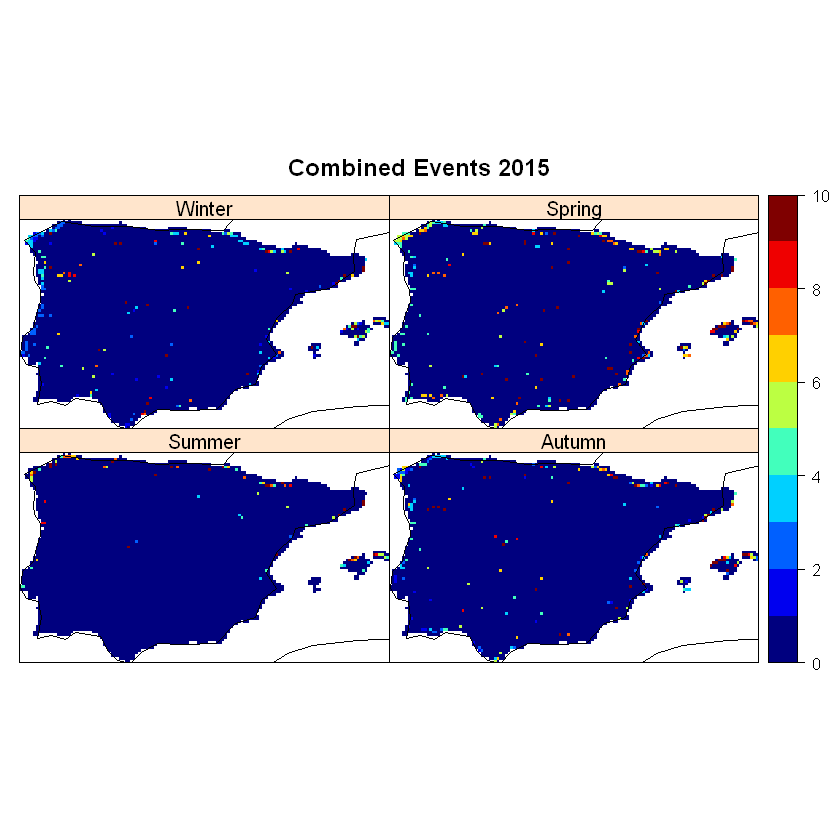

In [25]:
year_2015 <- bindGrid(sum_comp_events$`2015`$Winter, sum_comp_events$`2015`$Spring, sum_comp_events$`2015`$Summer, sum_comp_events$`2015`$Autumn, dimension = "member", skip.temporal.check = TRUE)
spatialPlot(year_2015, main="Combined Events 2015", backdrop.theme="coastline", color.theme= "jet.colors", names.attr = c("Winter", "Spring", "Summer", "Autumn"),set.min = 0, set.max = 10, at = seq(0,10), as.table = TRUE)

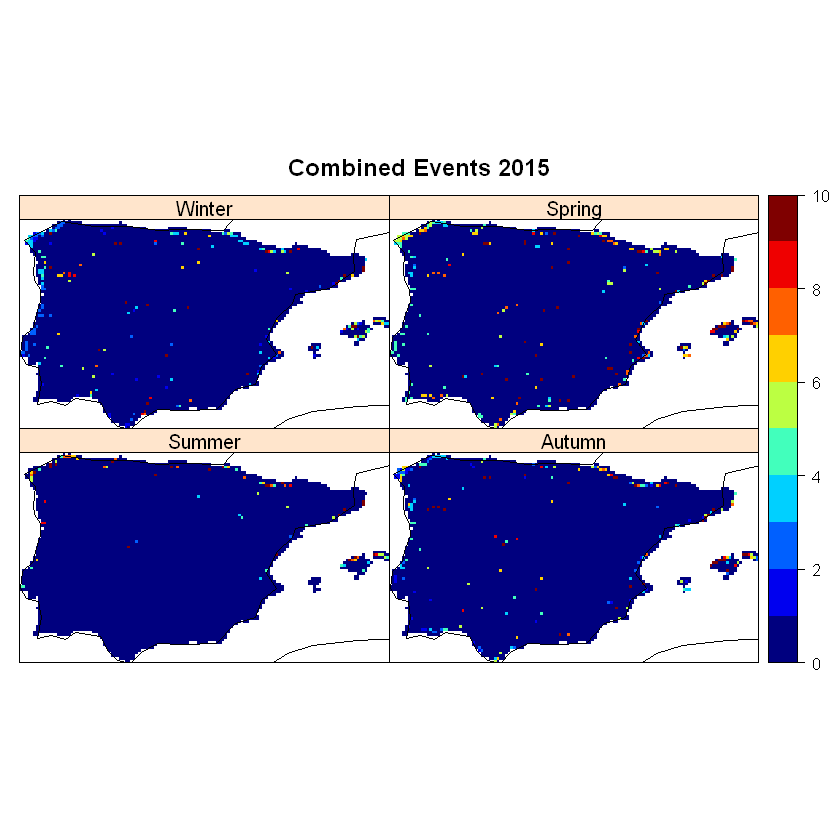

In [38]:
year_2015 <- bindGrid(sum_comp_events$`2015`$Winter, sum_comp_events$`2015`$Spring, sum_comp_events$`2015`$Summer, sum_comp_events$`2015`$Autumn, dimension = "member", skip.temporal.check = TRUE)
spatialPlot(year_2015, main="Combined Events 2015", backdrop.theme="coastline", color.theme= "jet.colors", names.attr = c("Winter", "Spring", "Summer", "Autumn"),set.min = 0, set.max = 10, at = seq(0,10), as.table = TRUE)

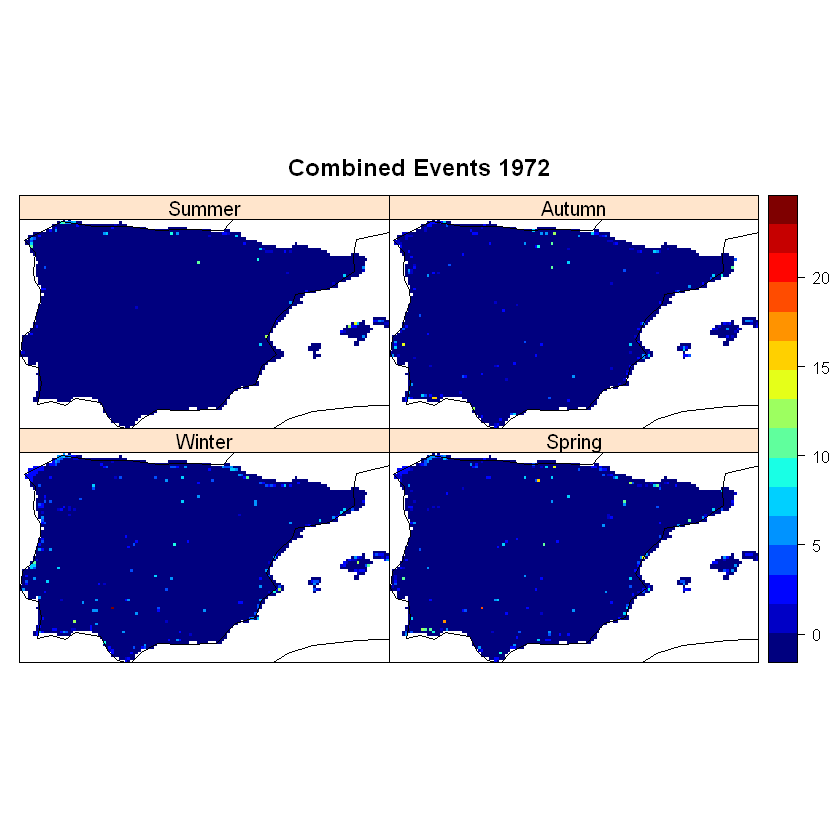

In [17]:
year_1972 <- bindGrid(sum_comp_events$`1972`$Winter, sum_comp_events$`1972`$Spring, sum_comp_events$`1972`$Summer, sum_comp_events$`1972`$Autumn, dimension = "member", skip.temporal.check = TRUE)
spatialPlot(year_1972, main="Combined Events 1972", backdrop.theme="coastline", color.theme= "jet.colors", names.attr = c("Winter", "Spring", "Summer", "Autumn"))

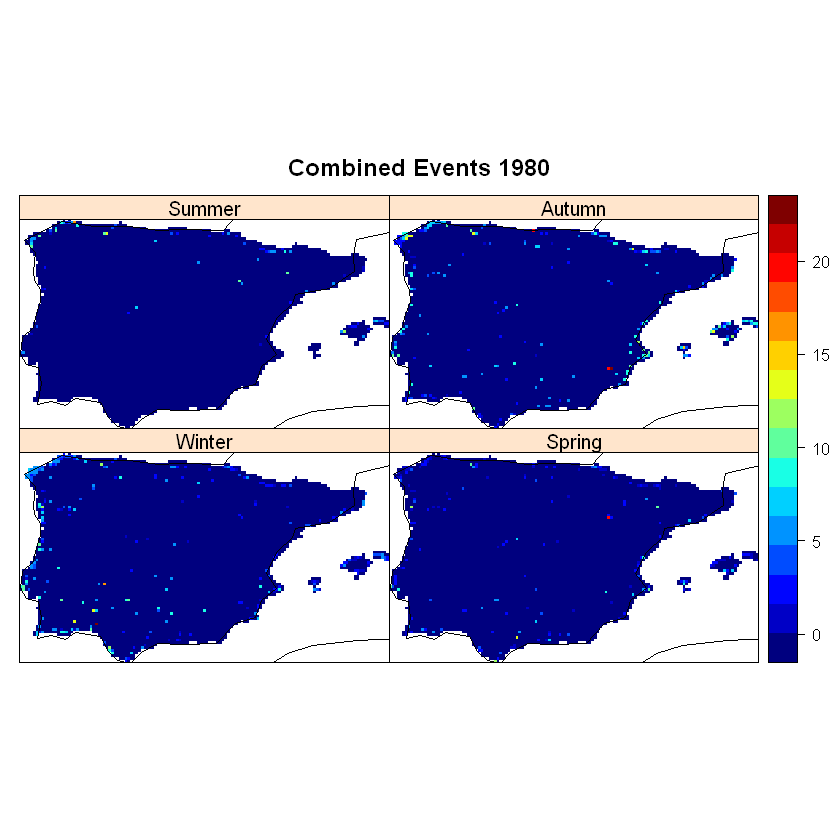

In [18]:
year_1980 <- bindGrid(sum_comp_events$`1980`$Winter, sum_comp_events$`1980`$Spring, sum_comp_events$`1980`$Summer, sum_comp_events$`1980`$Autumn, dimension = "member", skip.temporal.check = TRUE)
spatialPlot(year_1980, main="Combined Events 1980", backdrop.theme="coastline", color.theme= "jet.colors", names.attr = c("Winter", "Spring", "Summer", "Autumn"))

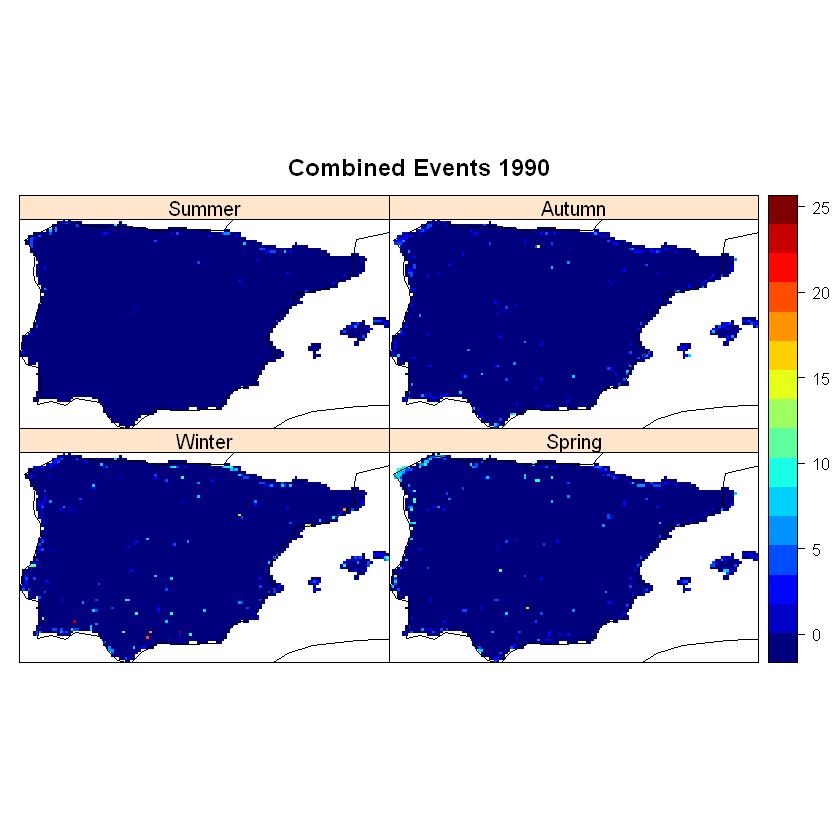

In [19]:
year_1990 <- bindGrid(sum_comp_events$`1990`$Winter, sum_comp_events$`1990`$Spring, sum_comp_events$`1990`$Summer, sum_comp_events$`1990`$Autumn, dimension = "member", skip.temporal.check = TRUE)
spatialPlot(year_1990, main="Combined Events 1990", backdrop.theme="coastline", color.theme= "jet.colors", names.attr = c("Winter", "Spring", "Summer", "Autumn"))

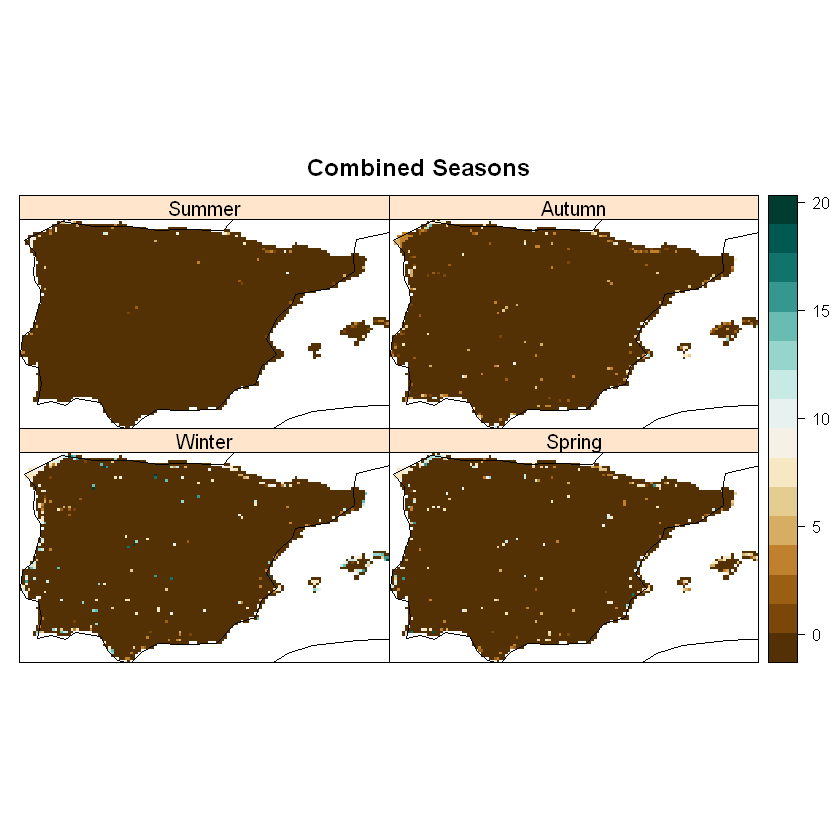

In [20]:
year_1976 <- bindGrid(sum_comp_events$`1976`$Winter, sum_comp_events$`1976`$Spring, sum_comp_events$`1976`$Summer, sum_comp_events$`1976`$Autumn, dimension = "member", skip.temporal.check = TRUE)
spatialPlot(year_1976, main="Combined Seasons", backdrop.theme="coastline", color.theme= "BrBG", names.attr = c("Winter", "Spring", "Summer", "Autumn"))

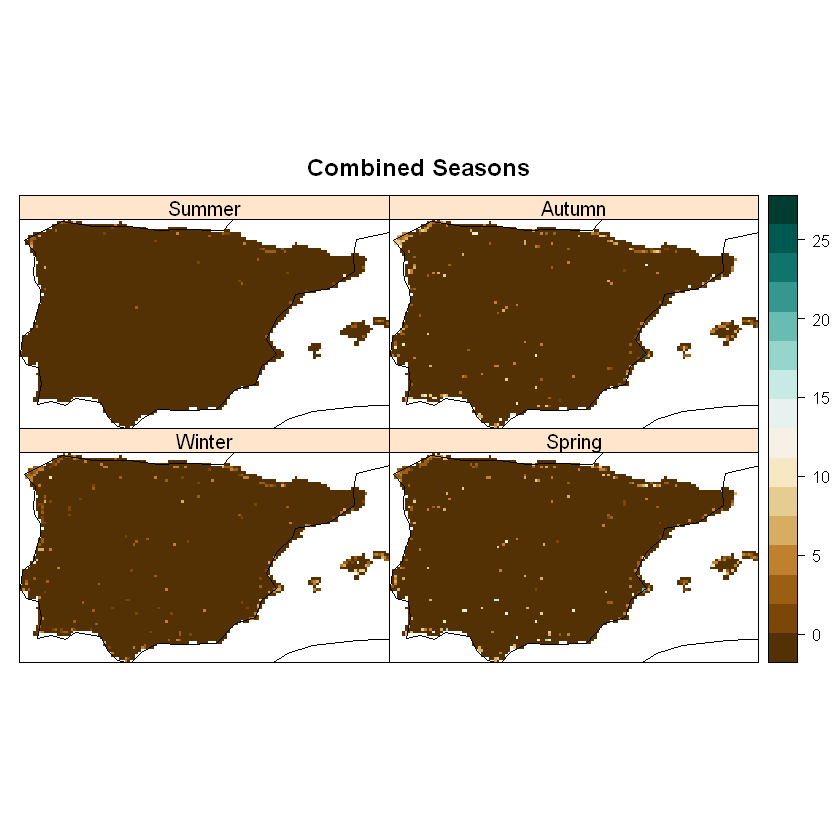

In [21]:
year_1977 <- bindGrid(sum_comp_events$`1977`$Winter, sum_comp_events$`1977`$Spring, sum_comp_events$`1977`$Summer, sum_comp_events$`1977`$Autumn, dimension = "member", skip.temporal.check = TRUE)
spatialPlot(year_1977, main="Combined Seasons", backdrop.theme="coastline", color.theme= "BrBG", names.attr = c("Winter", "Spring", "Summer", "Autumn"))